In [4]:
import yaml
import argparse
from early_ex.utils import *
from early_ex.model.devour import DevourModel
from early_ex.model.backbone import get_backbone
from early_ex.trainer.ce_branch import CEBranchTrainer
from tqdm.notebook import tqdm

print("Devour & Branch Trainer v0.9")

cfg = config("./configs/base.yml")
backbone = get_backbone(cfg)

model = DevourModel(cfg, N=cfg['num_exits'])
model.devour(backbone, cfg['backbone'])
trainset, testset = get_dataset(cfg)

# torch.set_default_tensor_type('torch.cuda.FloatTensor')


Devour & Branch Trainer v0.9
performance_dir
dataset_dir
backbone_dir
model_dir
csv_dir
Backbone model type:  mobilenet_v2
----------------------------------------
Scouting Module...
features   Sequential
classifier   Sequential
----------------------------------------
<Head_layer>
start: 0, end: 0
idx: *	 0 	 ConvNormActivation
idx: 	 1 	 InvertedResidual
idx: 	 2 	 InvertedResidual
idx: 	 3 	 InvertedResidual
idx: 	 4 	 InvertedResidual
idx: 	 5 	 InvertedResidual
idx: 	 6 	 InvertedResidual
idx: 	 7 	 InvertedResidual
idx: 	 8 	 InvertedResidual
idx: 	 9 	 InvertedResidual
idx: 	 10 	 InvertedResidual
idx: 	 11 	 InvertedResidual
idx: 	 12 	 InvertedResidual
idx: 	 13 	 InvertedResidual
idx: 	 14 	 InvertedResidual
idx: 	 15 	 InvertedResidual
idx: 	 16 	 InvertedResidual
idx: 	 17 	 InvertedResidual
idx: 	 18 	 ConvNormActivation
----------------------------------------
<Body_layer>
start: 1, end: 19
idx: 	 0 	 ConvNormActivation
idx: *	 1 	 InvertedResidual
idx: *	 2 	 InvertedRes

In [12]:
device = 'cpu'
test_loader = torch.utils.data.DataLoader(
    testset,  
    batch_size= 1, 
    shuffle=False, 
    num_workers=1,
    pin_memory=True)

backbone.eval()

acc = 0
total = 0
tbar = tqdm(test_loader)
backbone = backbone.cpu()
with torch.no_grad():
    for (i, data) in enumerate(tbar):
        input = data[0].cpu()
        label = data[1].cpu()
        total += input.shape[0]
        pred = backbone.forward(input)
        _ , pred = torch.max(pred, 1)
        acc += pred.eq(label).sum().item()
        tbar.set_description("total: {}, correct:{}".format(total, acc))
    print(print("accuracy: ", acc/ total))

  0%|          | 0/10000 [00:00<?, ?it/s]

Exception in thread Thread-6:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/home/jyp/lib/python3.6/site-packages/torch/utils/data/_utils/pin_memory.py", line 28, in _pin_memory_loop
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 113, in get
    return _ForkingPickler.loads(res)
  File "/home/jyp/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 289, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.current_process().authkey)
  File "/usr/lib/python3.

KeyboardInterrupt: 

In [ ]:
criterion = nn.CrossEntropyLoss().to(cfg['device'])
print('optimizer: Adam, lr: ',cfg['lr'])
optimizer = torch.optim.Adam(model.parameters(), lr = cfg['lr'])
print('scheduler = multistep LR')
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=cfg['backbone_training']['milestone'], gamma=0.5)
for n, m in model.feats.named_parameters():
    m.requires_grad_ = False
for n, m in model.head_layer.named_parameters():
    m.requires_grad_ = False
for n, m in model.fetc.named_parameters():
    m.requires_grad_ = False

for n, m in model.exactly.named_parameters():
    m.requires_grad_ = True
for n, m in model.tail_layer.named_parameters():
    m.requires_grad_ = True

In [3]:
# Branch training


train_loader = torch.utils.data.DataLoader(
        trainset, 
        batch_size=cfg['batch_size'], 
        shuffle=True,  
        num_workers=cfg['workers'],
        pin_memory=True) 

val_loader = torch.utils.data.DataLoader(
        testset, 
        batch_size=cfg['batch_size'], 
        shuffle=False,  
        num_workers=cfg['workers'],
        pin_memory=True) 

model = model.to(cfg['device'])


Files already downloaded and verified
Files already downloaded and verified


In [4]:

epochs = 1
for epoch in range(epochs):        
        train_tbar = tqdm(train_loader)
        val_tbar = tqdm(val_loader)
        model.train()
        print("Train")
        for n in range(model.n):
                model.exactly[n].cross = True
                model.exactly[n].gate = False
        
        for i, data in enumerate(train_tbar):
                losses = torch.zeros([model.n+1]).to(cfg['device'])
                input = data[0].to(cfg['device'])
                label = data[1].to(cfg['device'])
                pred = model.forward(input)

                for n in range(model.n):
                        m = model.exactly[n]
                        losses[n] = criterion(m.pred, label)
                losses[n+1] = criterion(pred, label)

                optimizer.zero_grad()
                loss = torch.sum(losses)
                loss.backward()
                optimizer.step()
        
        print("Validation")
        model.eval()
        total = 0
        corrects = []
        val_loss = []
        preds = []
        for n in range(model.n + 1):
                corrects.append(0.0)
                val_loss.append(0.0)
                preds.append(torch.zeros(0))
        
        with torch.no_grad():
                for i, (input, label) in enumerate(val_tbar):
                        input = input.to(cfg['device'])
                        label = label.to(cfg['device'])

                        pred = model.forward(input)
                        val_loss[model.n] += criterion(pred, label).item()
                        conf, pred = torch.max(pred, 1)
                        corrects[model.n] += pred.eq(label).sum().item()
                        
                        total += label.size(0)

                        for n in range(model.n):
                                m = model.exactly[n]
                                val_loss[n] += criterion(m.pred, label).item()
                                conf, _pred = torch.max(m.pred, 1)
                                corrects[n] += _pred.eq(label).sum().item()
                val_tbar.set_description('total: {}, c0: {}, c4:{}'.format(total, corrects[0], corrects[-1]))
                
                for n in range(model.n):
                        m = model.exactly[n]
                        acc = 100.* corrects[n] / total
                        val = val_loss[n] / total
                        print("Branch: {}, acc: {:.2f}, val_loss: {:.4f}"
                        .format(n, acc, val))
                acc = 100.* corrects[model.n] / total
                val = val_loss[model.n]        
                print("Output acc: {}, val_loss: {}".format(acc, val))
        torch.cuda.empty_cache()


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Train
Validation
Branch: 0, acc: 50.67, val_loss: 0.0157
Branch: 1, acc: 63.14, val_loss: 0.0148
Branch: 2, acc: 82.50, val_loss: 0.0132
Branch: 3, acc: 92.01, val_loss: 0.0122
Output acc: 92.74, val_loss: 17.173818290233612


  0%|          | 0/79 [00:00<?, ?it/s]

/home/jyp/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/jyp/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([10000, 10])
torch.Size([10000])
torch.Size([10000, 10])
torch.Size([10000])
torch.Size([10000, 10])
torch.Size([10000])
torch.Size([10000, 10])
torch.Size([10000])
<<<BEFORE Calibration>>>
[0] NLL Loss: 2.1003, ECE Loss: 0.1725
[1] NLL Loss: 1.4414, ECE Loss: 0.1123
[2] NLL Loss: 0.5235, ECE Loss: 0.0349
[3] NLL Loss: 0.5092, ECE Loss: 0.0620
<<<AFTER Calibration>>>
[0] NLL Loss: 1.6183, ECE Loss: 0.0974
[1] NLL Loss: 1.2326, ECE Loss: 0.0714
[2] NLL Loss: 0.5088, ECE Loss: 0.0062
[3] NLL Loss: 0.2633, ECE Loss: 0.0091
model saved...


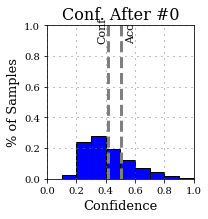

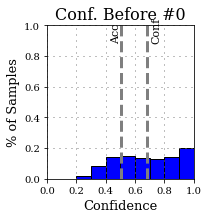

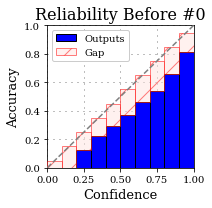

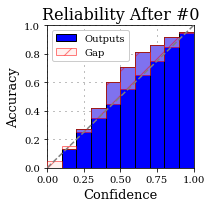

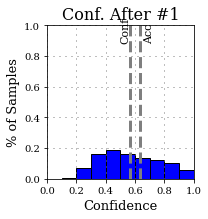

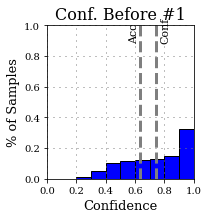

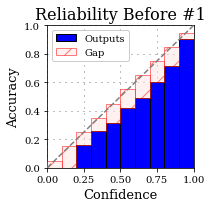

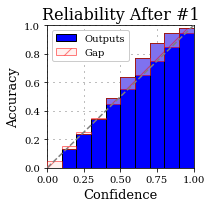

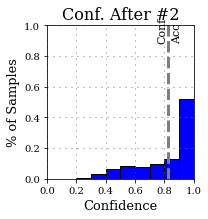

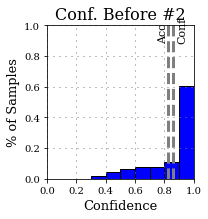

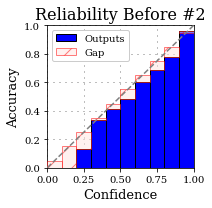

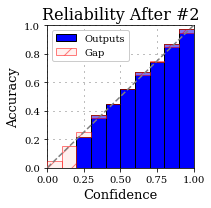

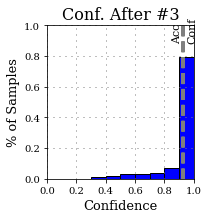

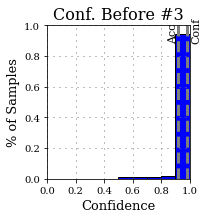

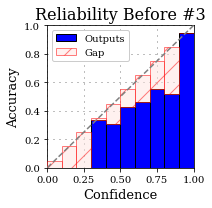

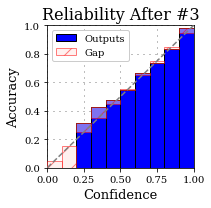

In [5]:
from early_ex.trainer.dce_branch import ECELoss
import torch.nn.functional as F
from early_ex import visualization
ece_criterion = ECELoss()
device = cfg['device']
labels = torch.zeros(0)
logits  = []
scaled = []
ex_num = model.n

for n in range(ex_num):
    model.exactly[n].temp = False
    model.exactly[n].temperature.requires_grad=True
    scaled.append(torch.zeros((0)))        
    logits.append(torch.zeros((0)))
    
tbar = tqdm(val_loader)
for i, data in enumerate(tbar):       
    input = data[0].to(device)
    label = data[1].to(device)
    model.forward(input)
    labels = torch.cat(
        (labels.to(device) ,label), dim=0)

    for n in range(ex_num):
        m = model.exactly[n]
        logits[n] = torch.cat((
            torch.tensor(logits[n]).to(device),  
            m.logits
            ), dim=0)

labels = torch.tensor(labels).long()

for n in tqdm(range(ex_num)):
    m = model.exactly[n]
    m.temperature.requires_grad=True

    optimizer = torch.optim.LBFGS(
        [m.temperature], 
        lr=0.1, 
        max_iter=1000)
    print(logits[n].shape)
    print(labels.shape)

    def eval():
        optimizer.zero_grad()
        m.temp = False
        scaled[n] = logits[n] / m.temperature
        loss = criterion(scaled[n] , labels)
        loss.backward(retain_graph = True)
        return loss
    optimizer.step(eval)

soft=[]
for n in range(ex_num):
    model.exactly[n].temp = True
    soft.append(torch.zeros((0)))
    soft[n] = F.softmax(scaled[n], dim=1)
    soft_np =  soft[n].cpu().detach().numpy()
    
    logits_np = logits[n].cpu().detach().numpy()
    labels_np = labels.cpu().detach().numpy()
    scaled_np = scaled[n].cpu().detach().numpy()
    conf_hist = visualization.ConfidenceHistogram()

    plt_test = conf_hist.plot(
        scaled_np, labels_np,title="Conf. After #"+str(n))
    name = cfg['csv_dir'] + cfg['path']['mode']\
        + 'conf_histogram_test_after_'+str(n)+'.png'
    plt_test.savefig(name, bbox_inches='tight')

    plt_test = conf_hist.plot(
        logits_np, labels_np,title="Conf. Before #"+str(n))
    name = cfg['csv_dir'] + cfg['path']['mode']\
        + 'conf_histogram_test_before_'+str(n)+'.png'
    plt_test.savefig(name,bbox_inches='tight')


    rel_diagram = visualization.ReliabilityDiagram()
    plt_test_2 = rel_diagram.plot(
        logits_np,labels_np,title="Reliability Before #"+str(n))
    name = cfg['csv_dir'] + cfg['path']['mode']\
        + 'rel_diagram_test_before_'+str(n)+'.png'
    plt_test_2.savefig(name,bbox_inches='tight')

    rel_diagram = visualization.ReliabilityDiagram()
    plt_test_2 = rel_diagram.plot(
        scaled_np,labels_np,title="Reliability After #"+str(n))
    name = cfg['csv_dir'] + cfg['path']['mode']\
        + 'rel_diagram_test_after_'+str(n)+'.png'
    plt_test_2.savefig(name,bbox_inches='tight')

print("<<<BEFORE Calibration>>>")
for n in range (ex_num):
    m.temp = True
    print("[{}] NLL Loss: {:.4f}, ECE Loss: {:.4f}".format(
        n, 
        criterion(logits[n], labels).item(), 
        ece_criterion(logits[n],labels).item())
        )

print("<<<AFTER Calibration>>>")
for n in range (ex_num):
    print("[{}] NLL Loss: {:.4f}, ECE Loss: {:.4f}".format(
        n, 
        criterion(scaled[n], labels).item(), 
        ece_criterion(scaled[n],labels).item())
        )

torch.save(model.state_dict(), cfg['model_path'])
print("model saved...")

In [6]:
device = 'cpu'
test_loader = torch.utils.data.DataLoader(
    testset,  
    batch_size= 1, 
    shuffle=False, 
    num_workers=cfg['workers'],
    pin_memory=True)

model.eval()

for i in range(model.n):
    m = model.exactly[i]
    m.temp = True
    model.gate[i] = True
    
    m.threshold = 0.9

total = 0
tbar = tqdm(test_loader)
model = model.to(device)
with torch.no_grad():
    for (i, data) in enumerate(tbar):
        input = data[0].to(device)
        label = data[1].to(device)
        total += input.shape[0]
        pred = model.forward(input)
        _ , pred = torch.max(pred, 1)
        acc += pred.eq(label).sum().item()
        tbar.set_description("total: {}, correct:{}".format(total, acc))
    print(print("accuracy: ", acc/ total))

  0%|          | 0/10000 [00:00<?, ?it/s]

accuracy:  0.933674
None


In [12]:
device = 'cpu'
test_loader = torch.utils.data.DataLoader(
    testset,  
    batch_size= 1, 
    shuffle=False, 
    num_workers=cfg['workers'],
    pin_memory=True)

backbone.eval()

acc = 0
total = 0
tbar = tqdm(test_loader)
backbone = backbone.to(device)
with torch.no_grad():
    for (i, data) in enumerate(tbar):
        input = data[0].to(device)
        label = data[1].to(device)
        total += input.shape[0]
        pred = backbone.forward(input)
        _ , pred = torch.max(pred, 1)
        acc += pred.eq(label).sum().item()
        tbar.set_description("total: {}, correct:{}".format(total, acc))
    print(print("accuracy: ", acc/ total))

  0%|          | 0/10000 [00:00<?, ?it/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  